# Setup

In [26]:
import sys
import os

%load_ext autoreload
%autoreload 2

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

# Import the MatLab prior work

from other_algs.teralasso import TeraLasso
from other_algs.EiGLasso import EiGLasso

# Standard imports

from new_validation import *
from generate_data import *
from regularizers import *

# Matplotlib
from cycler import cycler
linestyle_cycler = cycler('linestyle',['-','--','-.',':'])
color_cycler = cycler('color',['k','r','m','darkgreen'])
plt.rc('axes', prop_cycle=linestyle_cycler + color_cycler)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Algorithms to test

def GmGM_for_stats(dataset, structure, λ, reg: Regularizer = None):
    output = GmGM(
        dataset,
        structure,
        regularizer=reg,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        tol=1e-5
    )
    axes: set[Axis] = {
        axis
        for axes in structure.values()
        for axis in axes
    }
    output = shrink_sparsities(output, {axis: λ for axis in axes})
    return output

def GmGM_for_stats_just_0(dataset, structure, λ, reg: Regularizer = None):
    output = GmGM(
        {"dataset_0": dataset["dataset_0"]},
        {"dataset_0": structure["dataset_0"]},
        regularizer=reg,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        tol=1e-5
    )
    axes: set[Axis] = {
        axis
        for axes in structure.values()
        for axis in axes
    }
    output = shrink_sparsities(output, {axis: λ for axis in axes})
    return output

def GmGM_reg(strength):
    def to_return(dataset, structure, λ):
        return GmGM_for_stats(dataset, structure, λ, reg=L1({
            axis: strength
            for axes in structure.values()
            for axis in axes
        }))
    return to_return

def GmGM_reg_and_thresh(cutoff=1e-5, reg=None):
    def to_return(dataset, structure, λ):
        output = GmGM(
            dataset,
            structure,
            regularizer=reg,
            _always_regularize=True,
            _check_overstep_each_iter=True,
            tol=1e-5
        )
        axes: set[Axis] = {
            axis
            for axes in structure.values()
            for axis in axes
        }
        for axis in axes:
            if axis not in output:
                continue
            Psi = output[axis]
            Psi[np.abs(Psi) < cutoff*np.max(np.abs(Psi)) / λ] = 0
            output[axis] = Psi
        return output
    return to_return

def GmGM_for_stats_standardized(dataset, structure, λ, reg: Regularizer = None):
    # Standardize dataset
    dataset = {
        modality: (data - np.mean(data)) / np.std(data)
        for modality, data in dataset.items()
    }
    return GmGM_for_stats(dataset, structure, λ, reg=reg)

def TeraLasso_for_stats(dataset, structure, λ, reg: Regularizer = None):
    # Recall that TeraLasso takes a single matrix/tensor as input
    name, dataset = list(dataset.items())[0]

    # Input into TeraLasso
    betas = [λ] * (dataset.ndim - 1)
    output = TeraLasso(dataset, betas=betas)

    # Skip first as that will be batch
    axes = structure[name][1:]

    return {axis: out for axis, out in zip(axes, output)}

def EiGLasso_for_stats(dataset, structure, λ, reg: Regularizer = None):
    # Recall that TeraLasso takes a single matrix/tensor as input
    name, dataset = list(dataset.items())[0]

    # Input into TeraLasso
    output = EiGLasso(dataset, λ, λ)

    # Skip first as that will be batch
    axes = structure[name][1:]

    return {axes[0]: output[0], axes[1]: output[1]}

# Experiment 1: Matrix-Variate Data

In [8]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
    }
)

In [9]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_for_stats,
        "GmGM L1": GmGM_reg_and_thresh(cutoff=1e-3),#GmGM_reg(0.01),
        "EiGLasso": EiGLasso_for_stats,
        #"TeraLasso": TeraLasso_for_stats,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 40),
        "GmGM L1": 10**np.linspace(-3, 0, 40),
        "EiGLasso": 10**np.linspace(-3, 0, 40),
    },
    10,
    20,
    verbose=1
)

Attempt 1/10
Attempt 2/10
Attempt 3/10
Attempt 4/10
Attempt 5/10
Attempt 6/10
Attempt 7/10
Attempt 8/10
Attempt 9/10
Attempt 10/10


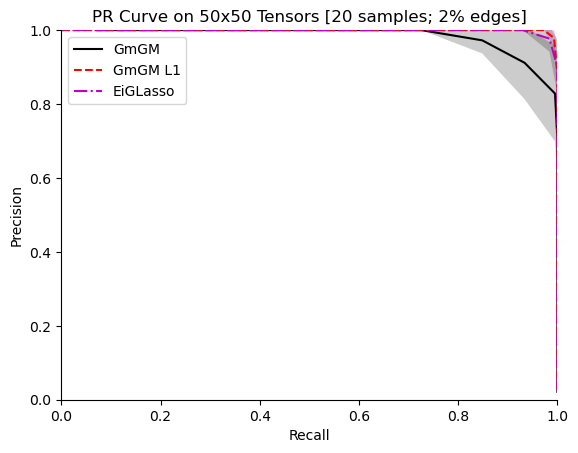

In [10]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50 Tensors [20 samples; 2% edges]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [6]:
fig.savefig("../out_figs/pr-curve-50x50-samples:20-percent:2.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50-samples:20-percent:2.png", bbox_inches="tight")

## Experiment 1b: Single Sample Matrix-Variate Data

In [11]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
    }
)

In [12]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_for_stats,
        "GmGM L1": GmGM_reg_and_thresh(cutoff=1e-3),#GmGM_reg(0.01),
        "EiGLasso": EiGLasso_for_stats,
        #"TeraLasso": TeraLasso_for_stats,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 100),
        "GmGM L1": 10**np.linspace(-3, 0, 100),
        "EiGLasso": 10**np.linspace(-3, 0, 100),
    },
    10,
    1,
    verbose=1
)

Attempt 1/10
Attempt 2/10
Attempt 3/10
Attempt 4/10
Attempt 5/10
Attempt 6/10
Attempt 7/10
Attempt 8/10
Attempt 9/10
Attempt 10/10


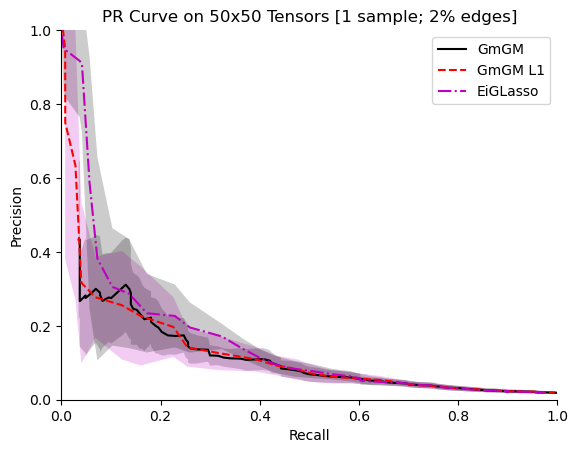

In [13]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50 Tensors [1 sample; 2% edges]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [10]:
fig.savefig("../out_figs/pr-curve-50x50-samples:1-percent:2.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50-samples:1-percent:2.png", bbox_inches="tight")

## Experiment 1c: Small Sample Matrix AR(1)

In [14]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatAutoregressive(p=1),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatAutoregressive(p=1),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
    }
)

In [15]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_for_stats,
        "GmGM L1": GmGM_reg_and_thresh(cutoff=1e-3),#GmGM_reg(0.01),
        "EiGLasso": EiGLasso_for_stats,
        #"TeraLasso": TeraLasso_for_stats,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 100),
        "GmGM L1": 10**np.linspace(-3, 0, 100),
        "EiGLasso": 10**np.linspace(-3, 0, 100),
    },
    10,
    1,
    verbose=1
)

Attempt 1/10
Attempt 2/10
Attempt 3/10
Attempt 4/10
Attempt 5/10
Attempt 6/10
Attempt 7/10
Attempt 8/10
Attempt 9/10
Attempt 10/10


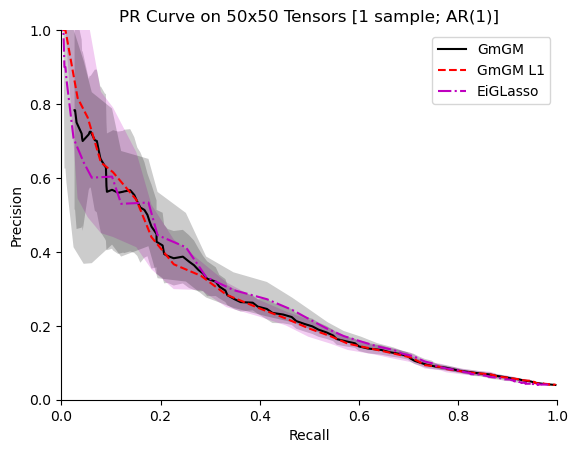

In [16]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50 Tensors [1 sample; AR(1)]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [17]:
fig.savefig("../out_figs/pr-curve-50x50-samples:1-ar:1.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50-samples:1-ar:1.png", bbox_inches="tight")

## Experiment 1d: LSM AR(1)

In [18]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatAutoregressive(p=1),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatAutoregressive(p=1),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
    }
)

In [19]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_for_stats,
        "GmGM L1": GmGM_reg_and_thresh(cutoff=1e-3),#GmGM_reg(0.01),
        "EiGLasso": EiGLasso_for_stats,
        #"TeraLasso": TeraLasso_for_stats,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 100),
        "GmGM L1": 10**np.linspace(-3, 0, 100),
        "EiGLasso": 10**np.linspace(-3, 0, 100),
    },
    10,
    20,
    verbose=1
)

Attempt 1/10
Attempt 2/10
Attempt 3/10
Attempt 4/10
Attempt 5/10
Attempt 6/10
Attempt 7/10
Attempt 8/10
Attempt 9/10
Attempt 10/10


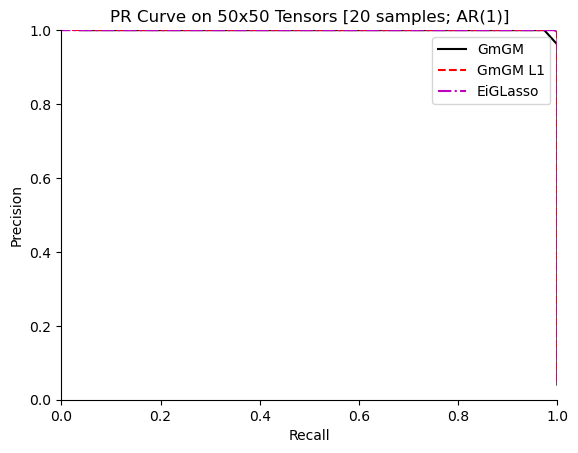

In [20]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50 Tensors [20 samples; AR(1)]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [21]:
fig.savefig("../out_figs/pr-curve-50x50-samples:20-ar:1.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50-samples:20-ar:1.png", bbox_inches="tight")

# Experiment 2: Tensor-Variate Data

In [11]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1", "axis_2"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "axis_2": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
        "axis_2": 50
    }
)

In [12]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_for_stats,
        "GmGM L1": GmGM_reg_and_thresh(cutoff=1e-3),#GmGM_reg(0.01),
        #"EiGLasso": EiGLasso_for_stats,
        "TeraLasso": TeraLasso_for_stats,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 50),
        "GmGM L1": 10**np.linspace(-3, 0, 50),
        "EiGLasso": 10**np.linspace(-3, 0, 50),
        "TeraLasso": 10**np.linspace(1, 4, 50),
    },
    10,
    1,
    verbose=1
)

Attempt 1/10
Attempt 2/10
Attempt 3/10
Attempt 4/10
Attempt 5/10
Attempt 6/10
Attempt 7/10
Attempt 8/10
Attempt 9/10
Attempt 10/10


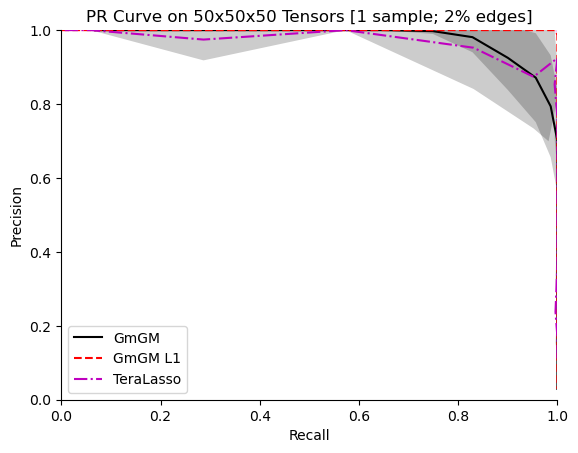

In [13]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50x50 Tensors [1 sample; 2% edges]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [14]:
fig.savefig("../out_figs/pr-curve-50x50x50-samples:1-percent:2.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50x50-samples:1-percent:2.png", bbox_inches="tight")

## Experiment 2b: SST AR(1)

In [22]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "axis_1", "axis_2"),
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatAutoregressive(p=1),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatAutoregressive(p=1),
        ),
        "axis_2": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatAutoregressive(p=1),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
        "axis_2": 50
    }
)

In [23]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_for_stats,
        "GmGM L1": GmGM_reg_and_thresh(cutoff=1e-3),#GmGM_reg(0.01),
        #"EiGLasso": EiGLasso_for_stats,
        "TeraLasso": TeraLasso_for_stats,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 50),
        "GmGM L1": 10**np.linspace(-3, 0, 50),
        "EiGLasso": 10**np.linspace(-3, 0, 50),
        "TeraLasso": 10**np.linspace(1, 4, 50),
    },
    10,
    1,
    verbose=1
)

Attempt 1/10
Attempt 2/10
Attempt 3/10
Attempt 4/10
Attempt 5/10
Attempt 6/10
Attempt 7/10
Attempt 8/10
Attempt 9/10
Attempt 10/10


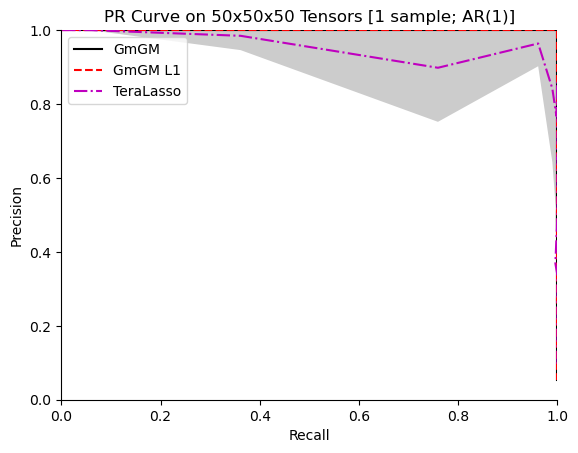

In [24]:
fig, ax = plot_prec_recall(results, "axis_0", generator)
ax.set_title("PR Curve on 50x50x50 Tensors [1 sample; AR(1)]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [25]:
fig.savefig("../out_figs/pr-curve-50x50x50-samples:1-ar:1.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-50x50x50-samples:1-ar:1.png", bbox_inches="tight")

# Experiment 3: Shared Axis

In [15]:
generator = DatasetGenerator(
    structure={
        "dataset_0": ("axis_0", "shared"),
        "dataset_1": ("shared", "axis_1")
    },
    generator={
        "axis_0": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "axis_1": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
        "shared": PrecMatGenerator(
            core_type="coreless",
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.02),
        ),
    },
    size={
        "axis_0": 50,
        "axis_1": 50,
        "shared": 50
    }
)

In [16]:
results = measure_prec_recall(
    generator,
    {
        "GmGM": GmGM_for_stats,
        "Unimodal GmGM": GmGM_for_stats_just_0,
        "GmGM L1": GmGM_reg_and_thresh(cutoff=1e-3),#GmGM_reg(0.01),
        "EiGLasso": EiGLasso_for_stats,
        #"TeraLasso": TeraLasso_for_stats,
    },
    {
        "GmGM": 10**np.linspace(-3, 0, 40),
        "Unimodal GmGM": 10**np.linspace(-3, 0, 40),
        "GmGM L1": 10**np.linspace(-3, 0, 40),
        "EiGLasso": 10**np.linspace(-3, 0, 40),
    },
    10,
    1,
    verbose=1
)

Attempt 1/10
Attempt 2/10
Attempt 3/10
Attempt 4/10
Attempt 5/10
Attempt 6/10
Attempt 7/10
Attempt 8/10
Attempt 9/10
Attempt 10/10


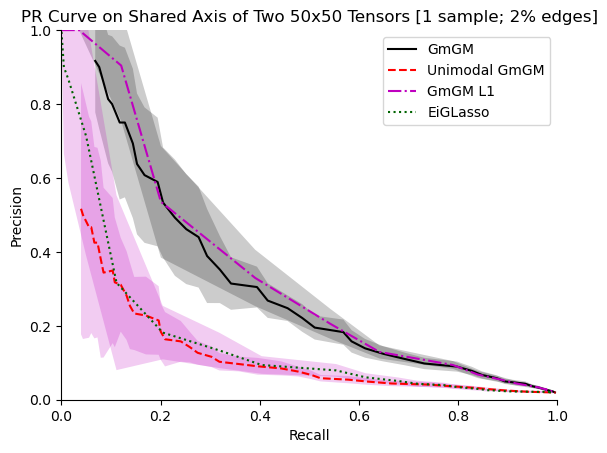

In [17]:
fig, ax = plot_prec_recall(results, "shared", generator)
ax.set_title("PR Curve on Shared Axis of Two 50x50 Tensors [1 sample; 2% edges]")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
pass

In [18]:
fig.savefig("../out_figs/pr-curve-shared-50x50-samples:1-percent:2.svg", bbox_inches="tight")
fig.savefig("../out_figs/pr-curve-shared-50x50-samples:1-percent:2.png", bbox_inches="tight")